## Домашнее задание

Решить задачу с [винами](https://www.kaggle.com/rajyellow46/wine-quality), оформив ее в виде CrispDM-подхода

## 1. Описание

Даны два датасета с видами красного и белого португальского вина "Vinho Verde". Из-за проблем конфиденциальности и логистики доступны только физико-химические параметры вин (признаки) и параметр оценки качества (целевая переменная) (нет данных о типах винограда, марке вина, цене продажи и т.д.). 

Эти датасеты можно рассматривать как для решения задачи классификации, так и для задачи регрессии. Классы упорядочены, но не сбалансированы. Нет уверенности, что все переменные актуальны.

## 2. Data Understanding

### 2.1. Import Libraries

In [1]:
# modelling helpers
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

# data handling and preparation
import numpy as np
import pandas as pd

# visualization
from jupyterthemes import jtplot
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
jtplot.style()

### 2.2. Helping Functions

In [2]:
def plot_variable_importance(X , y):
    tree = RandomForestRegressor(random_state = 419)
    tree.fit(X, y)
    plot_model_var_imp(tree, X, y)
    
def plot_model_var_imp(model, X, y):
    imp = pd.DataFrame( 
        model.feature_importances_  , 
        columns = ['Importance'] , 
        index = X.columns 
    )
    imp = imp.sort_values(['Importance'], ascending=True)
    imp[:10].plot(kind = 'barh')

### 2.3. Load data

In [4]:
data = pd.read_csv('..\data\external\winequalityN.csv')

In [5]:
data.head()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,white,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,white,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,white,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [6]:
data.shape

(6497, 13)

**Описание переменных**

Признаки:
* постоянная кислотность
* переменная кислотность
* лимонная кислота
* остаточный сахар
* хлориды
* свободный диоксид серы
* суммарный диоксид серы
* плотность
* pH
* сульфаты
* алкоголь

Целевая переменная (данные основаны на вкусовых ощущениях):
* качество вина (от 0 до 10)

### 2.4. EDA

#### 2.4.1. Предварительный анализ

In [7]:
data.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,6487.000000,6489.000000,6494.000000,6495.000000,6495.000000,6497.000000,6497.000000,6497.000000,6488.000000,6493.000000,6497.000000,6497.000000
mean,7.216579,0.339691,0.318722,5.444326,0.056042,30.525319,115.744574,0.994697,3.218395,0.531215,10.491801,5.818378
std,1.296750,0.164649,0.145265,4.758125,0.035036,17.749400,56.521855,0.002999,0.160748,0.148814,1.192712,0.873255
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000,5.000000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000,6.000000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000,6.000000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,9.000000


У нас нет сведений относительно единиц измерения каждого признака, поэтому мы можем предположить, что большинство признаков (содержание сульфатов, кислот и т.д.) измеряются с использованием весовых мер, например, мг или г, плотность и pH - в относительных единицах, а алкоголь - в промилле, поэтому будем считать, что все минимальные и максимальные значения возможны, и выбросов нет.

#### 2.4.2. Корреляция признаков

Построим корреляционную матрицу с использованием *seaborn.heatmap(...)*

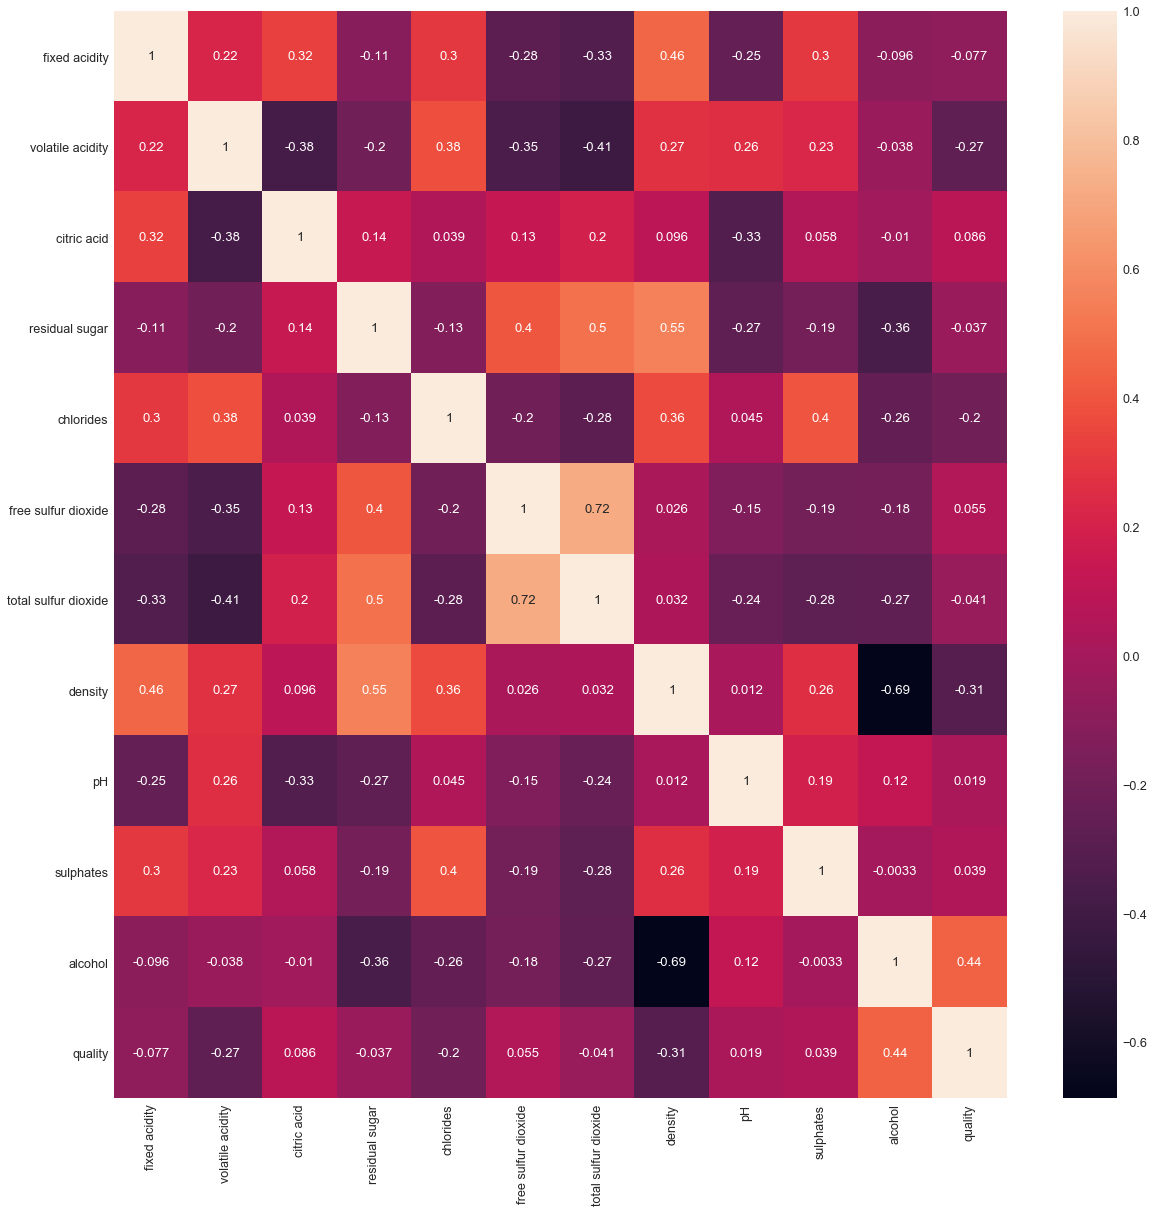

In [8]:
corr = data.corr()

fig, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True, ax=ax)
plt.show()

По корреляционной матрице можем наблюдать, что качество вина сильно зависит от содержания алкоголя, а он, в свою очередь, сильно зависит от плотности вина.

#### 2.4.3. Распределение переменных

Посмотрим, насколько распределение каждой переменной близко к нормальному

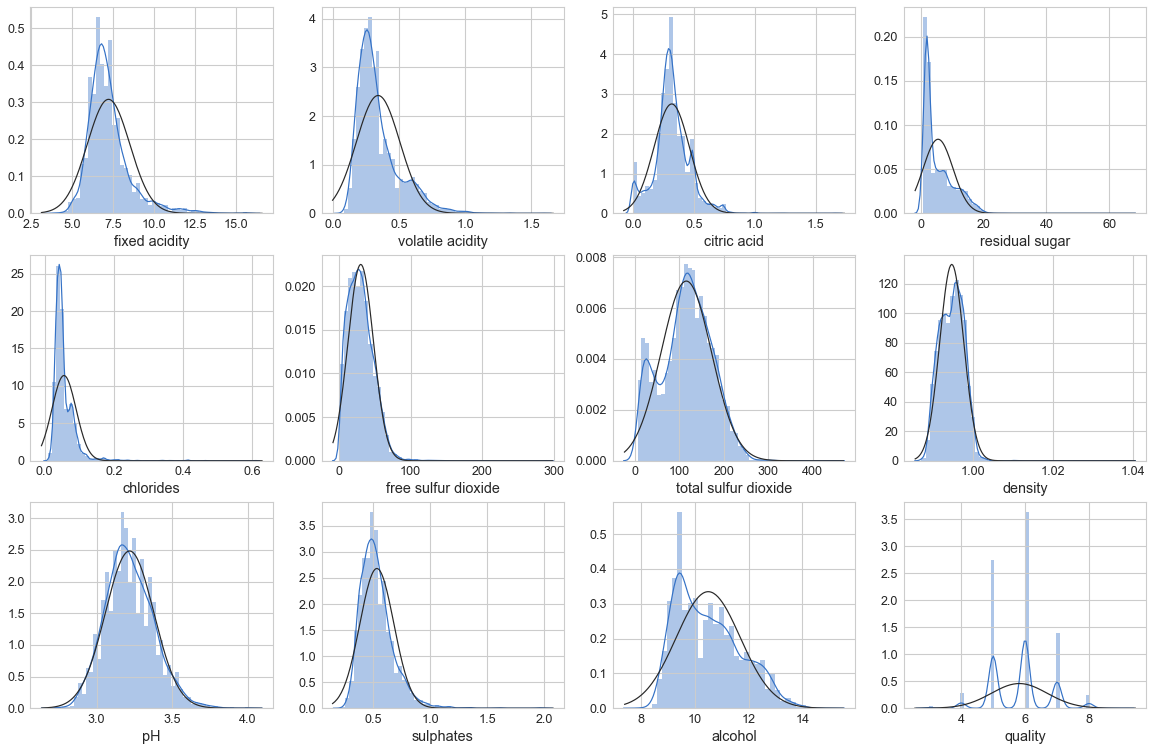

In [26]:
plt.figure(figsize = (20,22))

for i in range(1,13):
    plt.subplot(5,4,i)
    sns_plot = sns.distplot(data[data.columns[i]], fit=norm)
    plt.savefig('data_distribution.png')

## 3. Data Preparation

### 3.1. Преобразование категориальных переменных

В датасете присутствует единственный категориальный признак - тип вина.

In [10]:
obj_cols = list(data.select_dtypes(include=['object']).columns)
for col in data[obj_cols]:
    print(f'{col}:')
    print(f'Len of unique items list: {len(data[col].unique())}')
    print(f'{data[col].unique()}')
    print('-'*40)

type:
Len of unique items list: 2
['white' 'red']
----------------------------------------


 Перекодируем соответствующий тип вина в 0 (белое) и 1 (красное).

In [11]:
mappings = {'white': 0, 'red': 1}
data_ext = data.applymap(lambda s: mappings.get(s) if s in mappings else s)

### 3.2. Заполнение пропусков

Заменим пропуски на медианные значения.

In [12]:
data_ext.isna().sum()

type                     0
fixed acidity           10
volatile acidity         8
citric acid              3
residual sugar           2
chlorides                2
free sulfur dioxide      0
total sulfur dioxide     0
density                  0
pH                       9
sulphates                4
alcohol                  0
quality                  0
dtype: int64

In [13]:
data_ext.fillna(data_ext.mean(), inplace=True)

In [14]:
data_ext.isna().sum()

type                    0
fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

### 3.3. Создание датасетов

In [15]:
X = data_ext.drop(columns=['quality'])
y = data_ext['quality']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

#### 3.3.1. Важность признаков

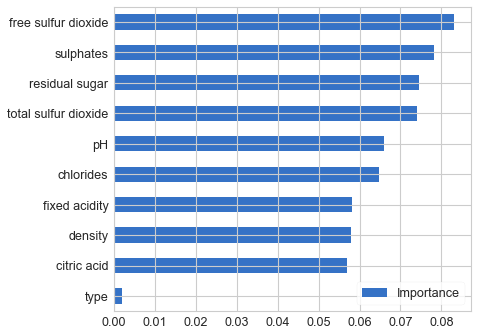

In [16]:
plot_variable_importance(X_train, y_train)

## 4. Моделирование

**Выбор модели**

Для построения модели и решения задачи регрессии будем использовать RandomForestRegressor(...)

In [17]:
model = RandomForestRegressor(random_state=419)

**Обучение модели**

In [18]:
model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=419, verbose=0, warm_start=False)

## 5. Оценка модели

Оценивать модель будем с использованием RMSE

In [19]:
y_predict = model.predict(X_test)

print(f'RMSE evaluation: {mean_squared_error(y_test, y_predict, squared=False):.4f}')

RMSE evaluation: 0.6233


## 6. Развертывание модели

Сохраним модель в *.csv файл

In [20]:
pred = pd.DataFrame({'quality_pred': y_predict})
data_new = pd.concat([data_ext, pred], axis=1)
data_new.head()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,quality_pred
0,0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6,5.36
1,0,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6,6.43
2,0,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6,5.23
3,0,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6,5.21
4,0,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6,5.50


In [92]:
data_new.to_csv('winequality_pred.csv')

**Сохрание модели в pickle**

In [22]:
import pickle

with open('..\models\wine_quality_random_forest_model.pickle', 'wb') as out_fp:
    pickle.dump(model, out_fp)